Plan:
- [] read one more time to understand all nits and pieces
- [] refactoring
- [] restructure storyline
- [] add required references
- [] stretch goal: add more examples

# A/B TESTING

In [77]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import stats
from collections import namedtuple
from dataclasses import dataclass

%matplotlib inline

Habrahabr article: https://habr.com/ru/post/653363/

Weighing fishes

First rod gave 300 fishes with weight 500+-150, the second rod - 300 with weight 530+-150.

> “The preferred best practice for getting reproducible pseudorandom numbers is to instantiate a generator object with a seed and pass it around” — Robert Kern, [NEP19](https://numpy.org/neps/nep-0019-rng-policy.html).

# 1. Generating data

In [2]:
rng = np.random.default_rng(42)
N = 300
fish_rod_1 = rng.normal(loc=500, scale=150, size=N)
fish_rod_2 = rng.normal(loc=530, scale=150, size=N)

fish_rod_1[:10]

array([545.70756196, 344.00238406, 612.56767937, 641.08470746,
       207.3447217 , 304.67307397, 519.17606048, 452.56361115,
       497.47982637, 372.04341086])

## 1.1. First glance analysis

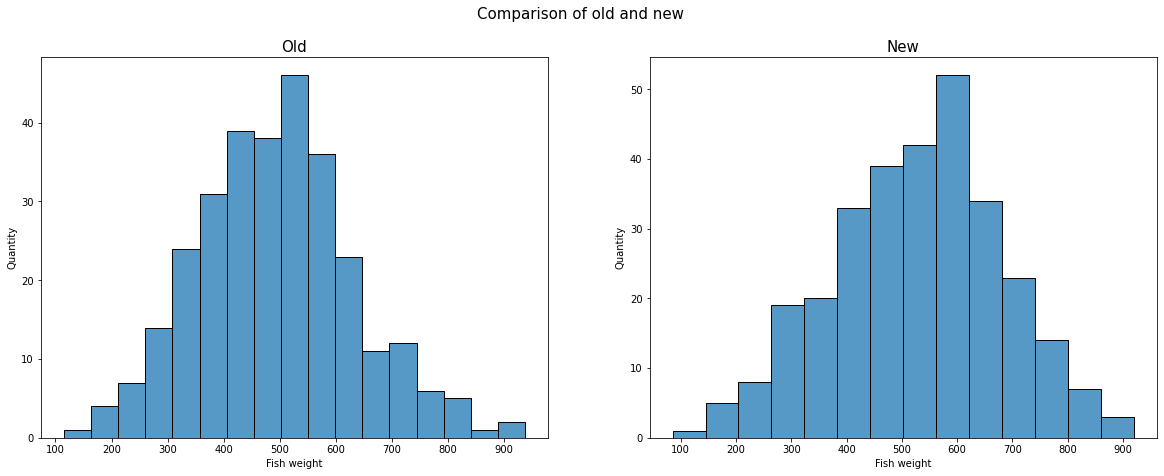

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

fig.suptitle("Comparison of old and new", fontsize=15)
for ax, fish_dist, fish_dsc in zip(axes, [fish_rod_1, fish_rod_2], ["Old", "New"]):
    ax.set_title(fish_dsc, size=15)
    ax.set(xlabel="Fish weight", ylabel="Quantity")
    # set step of 100 for x ticks
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    sns.histplot(data=fish_dist, ax=ax)

As we can see `New` weight distribution is skewed slightly to the right towards heavier weights which does make sense since average weight with new is 530 and with old - 500.

But can we say that the new is definitely better than the old one? No, of course not. There is still room for randomness/coincidence.

## 1.2. Normal distribution

Offset from normal distribution is highly unlikely but if it is it should be affected by some probability distribution.

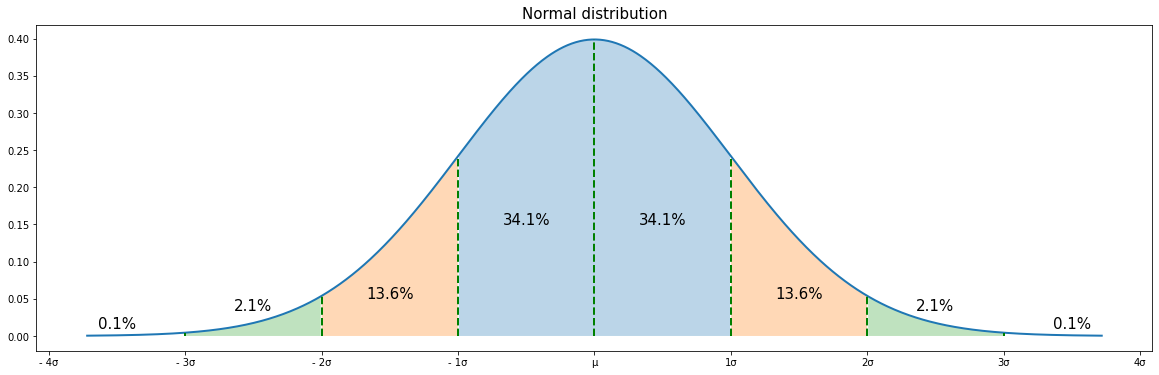

In [4]:
_, ax = plt.subplots(figsize=(20, 6))
# get normal distribution func
norm_rv = stats.norm(loc=0, scale=1)

# generate a thousand of values in boundaries of instantiated normal distribution
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 1_000)
# lw = line width
ax.plot(x, norm_rv.pdf(x), lw=2)

# middle of the distribution (loc)
ax.vlines(0, 0, norm_rv.pdf(0), color="g", lw=2, linestyles="dashed")

# +- one sigma
ax.vlines([-1, 1], 0, norm_rv.pdf(1), color="g", lw=2, linestyles="dashed")
ax.fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > -1) & (x < 1))
ax.text(0.5, 0.15, "34.1%", size=15, ha="center")
ax.text(-0.5, 0.15, "34.1%", size=15, ha="center")

# +- two sigmas
ax.vlines([-2, 2], 0, norm_rv.pdf(2), color="g", lw=2, linestyles="dashed")
ax.fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > -2) & (x < -1) | (x > 1) & (x < 2))
ax.text(1.5, 0.05, "13.6%", size=15, ha="center")
ax.text(-1.5, 0.05, "13.6%", size=15, ha="center")

# +- three sigmas
ax.vlines([-3, 3], 0, norm_rv.pdf(3), color="g", lw=2, linestyles="dashed")
ax.fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > -3) & (x < -2) | (x > 2) & (x < 3))
ax.text(2.5, 0.035, "2.1%", size=15, ha="center")
ax.text(-2.5, 0.035, "2.1%", size=15, ha="center")

# +- four sigmas
ax.text(3.5, 0.01, "0.1%", size=15, ha="center")
ax.text(-3.5, 0.01, "0.1%", size=15, ha="center")

# set x ticks
x_locations = range(-5, 5)
x_labels = ["- 5σ", "- 4σ", "- 3σ", "- 2σ", "- 1σ", "μ", "1σ", "2σ", "3σ", "4σ", "5σ"]
ax.xaxis.set_major_locator(ticker.FixedLocator(x_locations))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
ax.set_title("Normal distribution", size=15)
plt.show()

Now let's describe the image above:
- distribution is symmetric
- it's unimodal - it has only one peak (moda). Around this peak the distribution is symmetric
- distributio is a function of density. That means that likelihood of getting in interval `(a;b)` is equal to area beneath the curve in the same interval `(a;b)`. Likelihood of getting in interval (-$\infty$, + $\infty$) is equal to 1. 
- Distribution follows probability low. In interval (-$\sigma$, +$\sigma$) there are 34.1% + 34.1% = 68.2% of values. In other words likelihood of getting in this interval is 68.2%. Or if to be more precise the area under the curve in interval (-$\sigma$, +$\sigma$) is 0.682.

~Don't know whether I should add note about gaussian distribution with formulas and plot.~

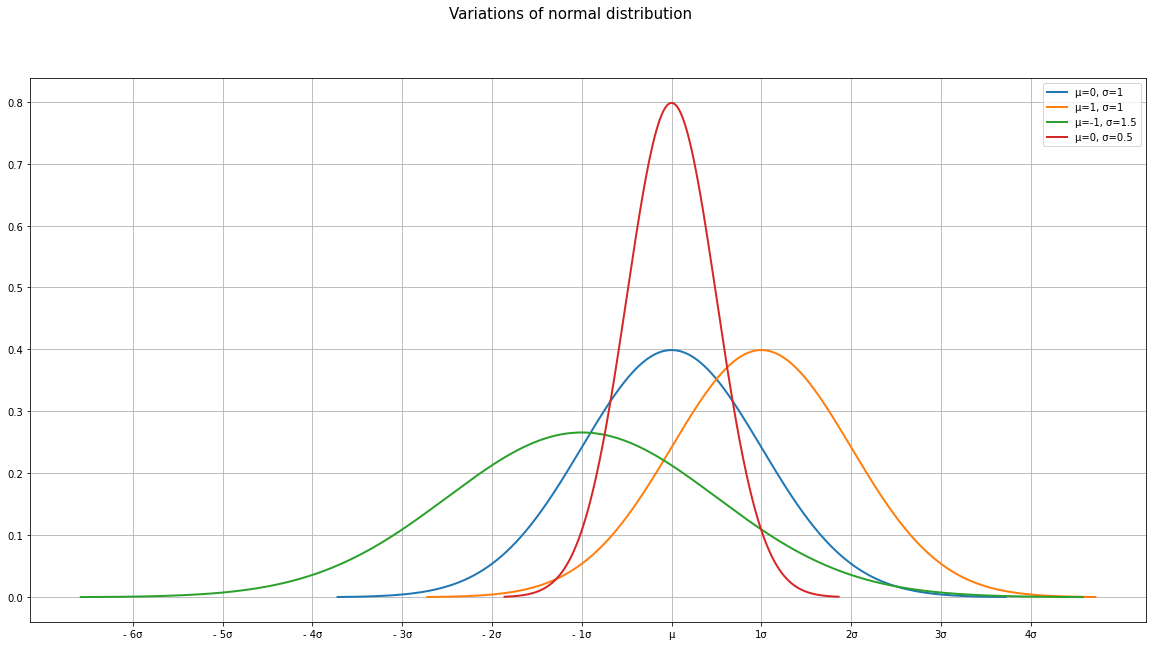

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))

norm_class = namedtuple("norm_dist_parameters", ["loc", "scale"])


@dataclass
class NormParams:
    loc: float
    scale: float

    def __str__(self) -> str:
        return f"μ={self.loc}, σ={self.scale}"


norm_list = [
    NormParams(0, 1),
    NormParams(1, 1),
    NormParams(-1, 1.5),
    NormParams(0, 0.5),
]

fig.suptitle("Variations of normal distribution", fontsize=15)
for norm_params in norm_list:
    norm_rv = stats.norm(loc=norm_params.loc, scale=norm_params.scale)
    x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 1_000)
    ax.plot(x, norm_rv.pdf(x), lw=2, label=norm_params)

x_locations = range(-6, 5)
x_labels = ["- 6σ", "- 5σ", "- 4σ", "- 3σ", "- 2σ", "- 1σ", "μ", "1σ", "2σ", "3σ", "4σ"]
ax.xaxis.set_major_locator(ticker.FixedLocator(x_locations))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
ax.legend()
ax.grid(True)
plt.show()

All of these distribution are variations of normal distribution. The only difference is in the mu value (center of distribution) and sigma (scale of the distribution, how "wide" it is).

The same way we shifted are mu and sigma away from norm (with loc=0, scale=1), we can turn any variation of normal distribution to norm form with help of Z score.

## 1.3. Central Limit Theory

As Central Limit Theory stated large quantity of any independent variables has distribution that is close to normal.

So we have 300 fishes. Let's take an experiment:
- we will take many time randomly 300 fishes in such a way that multiple fishes can be found more than once
- after that we will calculate average fish weight
- repeat step 1 and 2 many-many times and each time write down average weight value
- distribution of average weight should be closer to normal with increase of number of repetitions

Sample mean: 488.1142686641317, sample std: 151.90234802483994


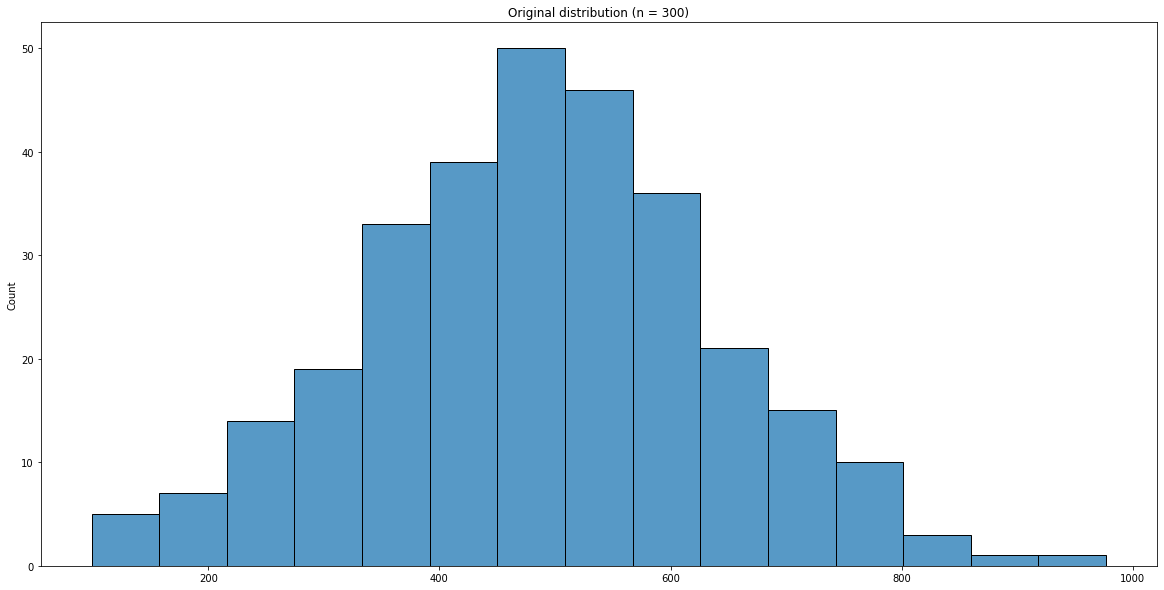

In [6]:
sample = rng.normal(loc=500, scale=150, size=N)
print(f"Sample mean: {sample.mean()}, sample std: {sample.std()}")

plt.figure(figsize=(20, 10))
ax = sns.histplot(data=sample)
ax.set_title("Original distribution (n = 300)", size=12)
plt.show()

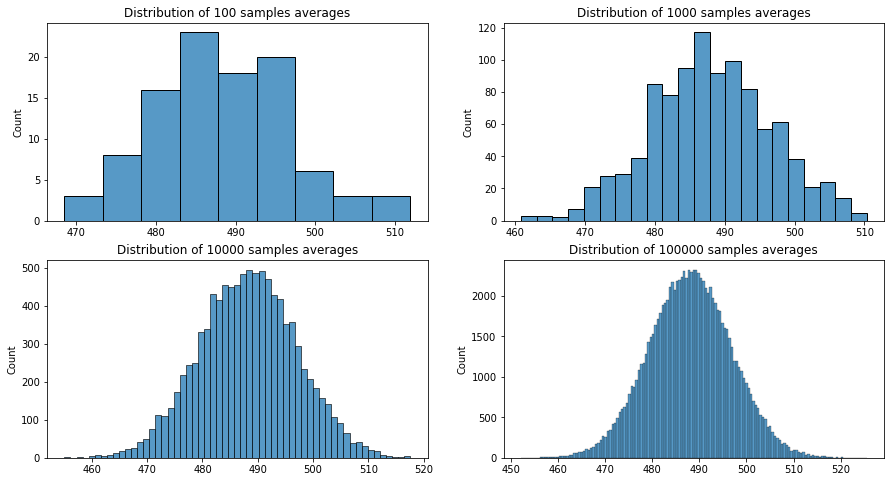

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
axes = axes.flatten()

for ax, size in zip(axes, [100, 1_000, 10_000, 100_000]):
    average_weights = [rng.choice(sample, size=N).mean() for _ in range(size)]
    sns.histplot(data=average_weights, ax=ax)
    ax.set_title(f"Distribution of {size} samples averages", size=12)

The bigger number of samples the more distribution looks like normal.

The bigger size of original sample the close this sample to general distribution. In other words the more fishes fisherman caught the more similar average weight of those fishes to average weight of fishes in the pond.
The same is true for standard deviation.

Since we don't know average weight of all fishes in the pond we cannot be 100% sure. That's why we need to add some value of uncertainty: 

$$ se = \frac{\sigma_x}{\sqrt{n}} $$

Average quadratic deviation equals to standard deviation of sample divided by square root of the size of sample.

# 2. Z-score

Z-score is a way to transform data into normal distribution with mean of 0 and standard deviation of 1.

$$ z_{i} = \frac{x_{i} - \bar{x}}{\sigma_{x}} $$

In order to transform our data into standard Z-scale we nee to subtract from each fish weight it's average and divide by standard deviation.

In [8]:
mu_z = fish_rod_1.mean()
std_z = fish_rod_1.std()

z_fish_rod_1 = (fish_rod_1 - mu_z) / std_z

print(z_fish_rod_1.mean())
print(z_fish_rod_1.std())
z_fish_rod_1[:5]

-8.385884579335349e-16
1.0


array([ 0.37233606, -1.07557184,  0.85228056,  1.05698542, -2.0565467 ])

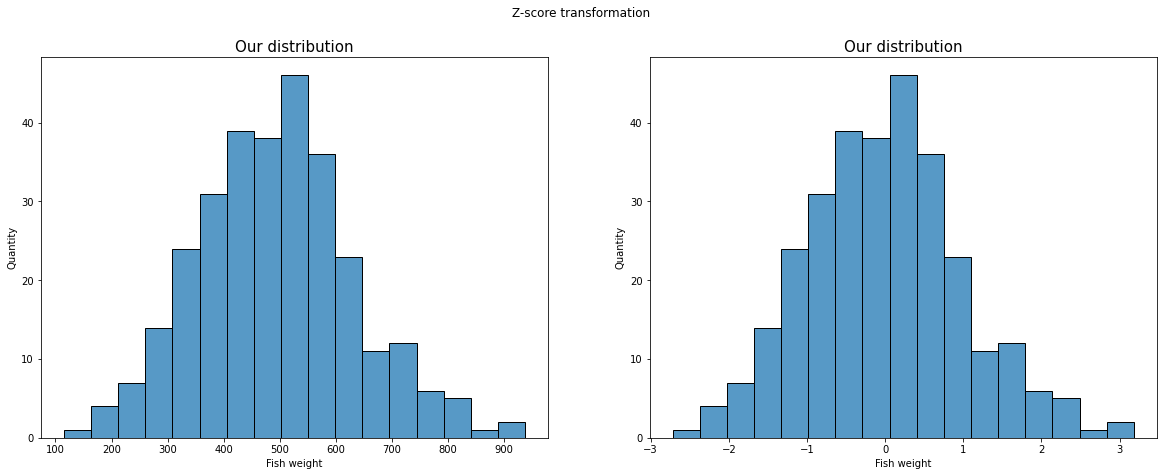

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
axes = axes.flatten()

fig.suptitle("Z-score transformation")
for ax, data, x_ticks_m in zip(axes, [fish_rod_1, z_fish_rod_1], [100, 1]):
    sns.histplot(data=data, ax=ax)
    ax.set(xlabel="Fish weight", ylabel="Quantity")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(x_ticks_m))
    ax.set_title("Our distribution", size=15)

The plots are similar but the main difference is in X axis: 
- because we subtracted from each value mean weight the whole distribution shifted towards left and now has mean value of zero
- as we also divided by standard deviation the whole distribution was squeezed. 
- now in X axis each tick means not weight units but rather units of standard deviation

That means that with help of Z-score transformation we can compare mean values of two properties as long as they have normal distribution because now all data points have not weight value, but rather value in std units.

## 2.1. General population

As our data has normal distribution we can say that:
- in interval $(-\sigma,+\sigma)$ we have 68.2% measurements, in other words out of 300 fishes most likely 205 has weight 500+-150
- in interval $(-2\sigma,+2\sigma)$ we have 95.4% of all measurements. That means that 95.4% of all fishes has weight 500+-150 grams.

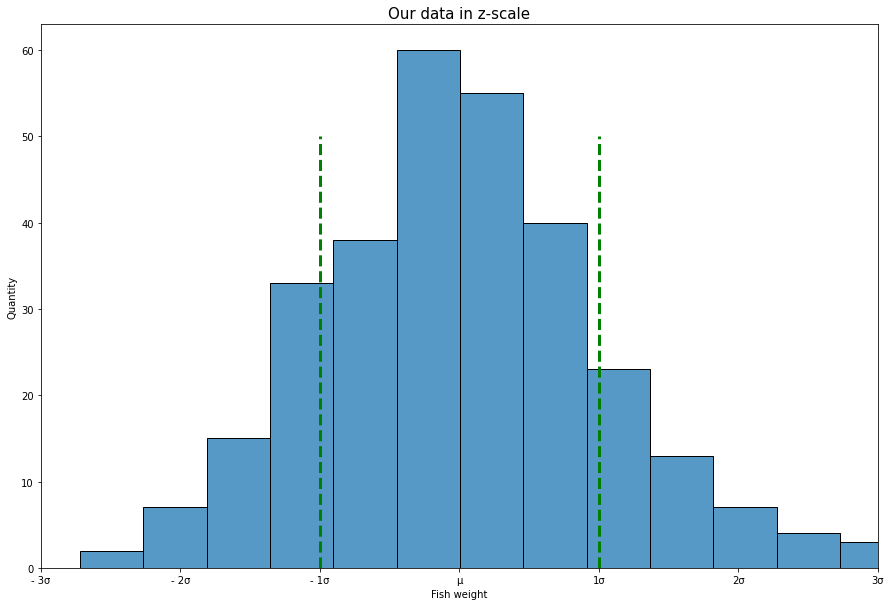

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.histplot(data=z_fish_rod_1, bins=13)
ax.set(xlabel="Fish weight", ylabel="Quantity")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("Our data in z-scale", size=15)
x_locations = range(-4, 4)
x_labels = ["- 4σ", "- 3σ", "- 2σ", "- 1σ", "μ", "1σ", "2σ", "3σ", "4σ"]
ax.xaxis.set_major_locator(ticker.FixedLocator(x_locations))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
plt.xlim([-3, 3])

ax.vlines([-1, 1], 0, 50, color="g", lw=3, linestyles="dashed")
plt.show()

In [11]:
# TODO: maybe fill up the distance between $-\sigma$ and $\sigma$

### 2.1.1. General population and a single fish

Let's image that there were no another rod. For convenience we can assume that parameters of mean=500 and std=150 is a general population. Because of it we don't need to divide our standard deviation on square root of number of elements in the sample.

Now the question is how likely it's to catch a fish with weight of 530? In order to find out let's use again z-score:

$$ z = \Large\frac{x - \mu}{\sigma} $$

$$ z = \frac{530-500}{150} = 0.2 $$

that means that weight of 530 deviates from average weight of general population (500) by 0.2 units of standard deviation.

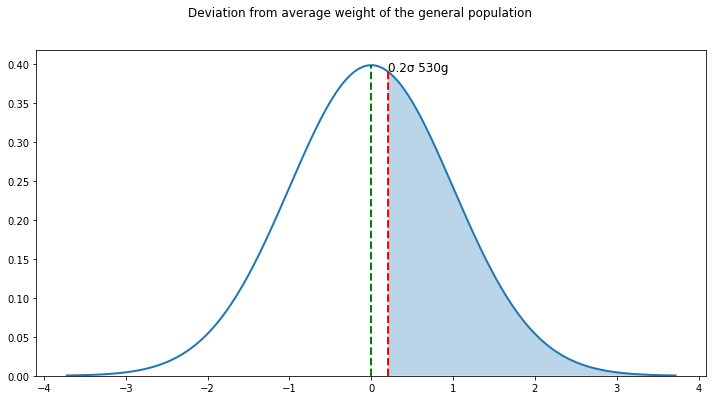

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Deviation from average weight of the general population")
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 1000)

norm_rv = stats.norm(loc=0, scale=1)
ax.plot(x, norm_rv.pdf(x), lw=2)
ax.vlines(0, 0, norm_rv.pdf(0), color="g", lw=2, linestyles="dashed")
ax.vlines(0.2, 0, norm_rv.pdf(0.2), color="r", lw=2, linestyles="dashed")
ax.text(0.2, norm_rv.pdf(0.2), "0.2σ 530g", size=12, ha="left")
ax.fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > 0.2))
ax.set_ylim(0)
plt.show()

Knowing deviation from average value we can calculate likelihood of catching a fish with weight higher than 530 grams. For this we can calculate are under the curve of an area to the right of 0.2σ (the part that is colored in blue). It will be our likelihood: 

In [74]:
# standardized normal distribution
norm_rv = stats.norm(loc=0, scale=1)
print(1 - norm_rv.cdf(0.2))

# original normal distribution without normalization
norm_rv = stats.norm(loc=500, scale=150)
print(1 - norm_rv.cdf(530))

0.420740290560897
0.420740290560897


Both functions return the same value of $p=0.42$. This is `p-value`, the likelihood of catching a fish with weight that is higher than 530 grams. 


The only difference between them is that in the first case normal distribution is standardized, while in the second we work with parameters of general population.

### 2.1.2. General population and multiple fishes

Alright, we've figured out how to calculate likelihood of a single fish, but what about multiple fishes, what is the likelihood of catching 4, 100 or even 300 fishes with average weight of 530 grams? For that we can use the same $z-score$ formula but with few tweaks: we will need modificator from central limit theory:

$$ \Large z = \frac{\bar{x} - \mu}{\frac{\sigma}{\sqrt{n}}}$$

where: 
- $\bar{x}$: average value in the sample
- $\mu$: average of the general population
- $\sigma$: standard deviation of the general population
- $n$: the size of the sample

Here we add modification to the standard deviation as we work with multiple elements.

Meaning of the formula above is that we introduced two hypothesis:

- $H_{0}$: base hypothesis says that the sample is in general population and average of the sample and general population are equal ($\bar{x} = \mu$)
- $H_{1}$: alternative hypothesis says the opposite. The sample is not in general population and averages are not equal($\bar{x} \neq \mu$) 

In order to accept or reject null hypothesis we need to calculate $z-score$ and $p-value$. In other words we calculate likelihood of $\bar{x}$ differs from $\mu$ by $z$ units of standard deviation. If this likelihood is ok for us then we accept null hypothesis, if not - reject it.

$$ z = \frac{530 - 500}{\frac{150}{\sqrt{4}}} = \frac{30}{75} = 0.4$$

Now we now that average of the sample and average of the general population differs by 0.4 units of standard deviation. Let's calculate the likelihood of it.

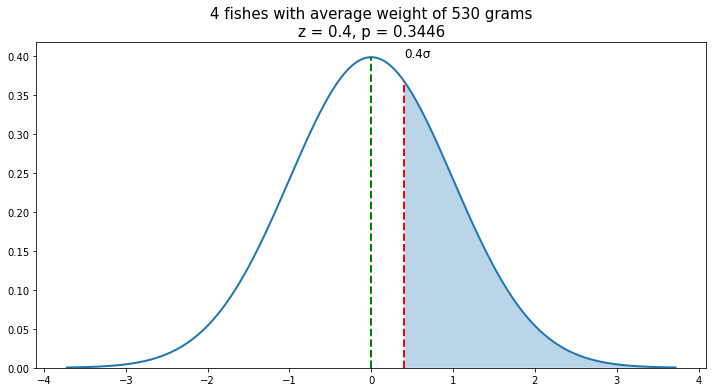

In [78]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 1000)

norm_rv = stats.norm(loc=0, scale=1)
ax.plot(x, norm_rv.pdf(x), lw=2)
ax.vlines(0, 0, norm_rv.pdf(0), color="g", lw=2, linestyles="dashed")
ax.vlines(0.4, 0, norm_rv.pdf(0.4), color="r", lw=2, linestyles="dashed")
ax.text(0.4, norm_rv.pdf(0), "0.4σ", size=12, ha="left")
ax.fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > 0.4))
ax.set_title(
    "4 fishes with average weight of 530 grams\nz = {:.1f}, p = {:.4f}".format(0.4, 1 - norm_rv.cdf(0.4)), size=15
)
ax.set_ylim(0)
plt.show()

Probability of catching 4 fishes with average weight of 530 grams we can calculate the same weight as we did for a single fish.

In [79]:
norm_rv = stats.norm(loc=0, scale=1)
print(1 - norm_rv.cdf(0.4))

0.3445782583896758


$P-value$ equals to 0.34.

As you can see the more we want to find fishes with average weight of 530 the higher is $z-score$ and lower $p-value$.

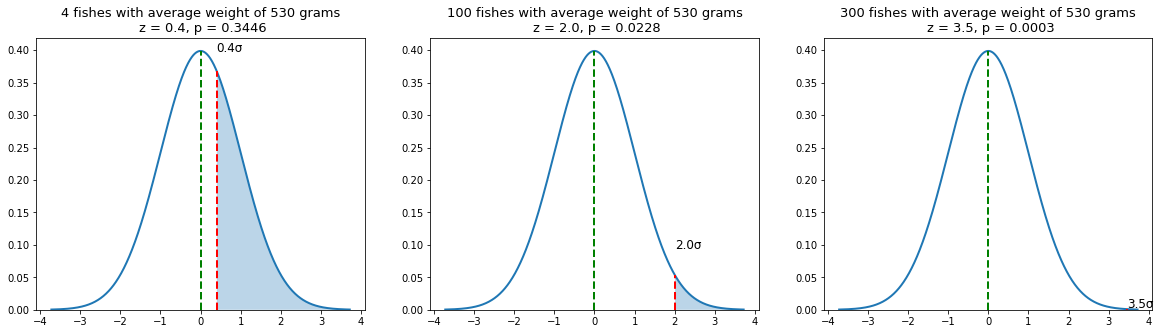

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 1000)
norm_rv = stats.norm(loc=0, scale=1)

fish = [4, 100, 300]

for i in range(3):
    z = (530 - 500) / (150 / np.sqrt(fish[i]))
    ax[i].plot(x, norm_rv.pdf(x), lw=2)
    ax[i].vlines(0, 0, norm_rv.pdf(0), color="g", lw=2, linestyles="dashed")
    ax[i].vlines(z, 0, norm_rv.pdf(z), color="r", lw=2, linestyles="dashed")
    ax[i].text(z, norm_rv.pdf(z - 0.3), "{:.1f}σ".format(z), size=12, ha="left")
    ax[i].fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > z))
    ax[i].set_title(
        "{:d} fishes with average weight of 530 grams\n z = {:.1f}, p = {:.4f}".format(fish[i], z, 1 - norm_rv.cdf(z)),
        size=13,
    )
    ax[i].set_ylim(0)

In other words probability of catching 4 fishes with average weight of 530 grams is 0.34 (34%), 100 fishes - 0.0228 (2.28%) and 300 fishes - 0.0003 (0.03%).

Having said that we can assume that the second rod was much better as only in 0.03% of cases we could be wrong.

But remember that we made an assumption that the data from the first rod is the general population when in fact it's a sample from the general distribution. Will it make our statistical conclusion wrong? Yes, it will. So now it's time to get rid of this assumption and make the final conclusion with correct numbers.

## 2.2. Two sample and many fishes

Now we have not a general population and a sample, but two sample out of couple of hundreds of fishes. In other words if we continued to catch fish average weights might have changed.

It's important that $z-score$ requires knowledge of standard deviations. So let's think that we have caught enough fishes and that let's us assume that $\sigma_{1}$ $\sigma_{2}$ are the same as in general population (in the whole pond). Otherwise we will have to use $t-criterion$ of Student.

| |$n$|$\mu$|$\sigma$|
|-|-|-|-|
|old bait|300|500|150| 
|new bait|300|530|150| 


As we remember from central limit theory we need to apply adjustment. Since we have two sample we need to apply adjustment twice:

$$ \Large z = \frac{\mu_{2} - \mu_{1}}{\sqrt{\frac{x^{2}_{1}}{n_{1}} + \frac{x^{2}_{2}}{n_{2}}}} $$

Meaning of this formula stays the same: we accept null hypothesis with equality of averages from both sample if the $p-value$ is high and reject if it is low.


$$ z = \frac{530-500}{\sqrt{\frac{150^{2}}{300} + \frac{150^{2}}{300}}} = \frac{30}{\sqrt{150}} \approx 2.45 $$

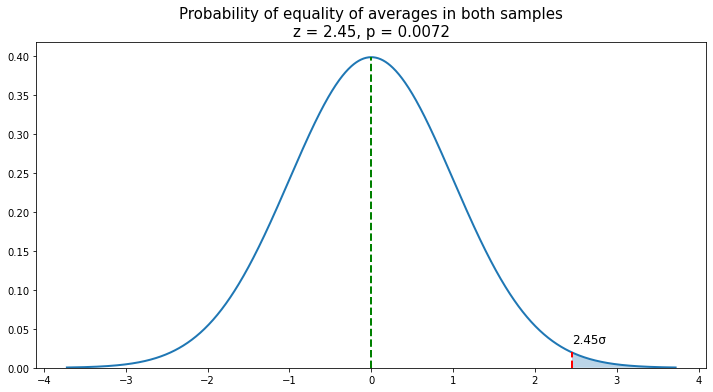

In [86]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 1000)

z = (530 - 500) / np.sqrt(150**2 / 300 + 150**2 / 300)
norm_rv = stats.norm(loc=0, scale=1)
ax.plot(x, norm_rv.pdf(x), lw=2)
ax.vlines(0, 0, norm_rv.pdf(0), color="g", lw=2, linestyles="dashed")
ax.vlines(z, 0, norm_rv.pdf(z), color="r", lw=2, linestyles="dashed")
ax.text(z, norm_rv.pdf(z - 0.2), "{:.2f}σ".format(z), size=12, ha="left")
ax.fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > z))
ax.set_title(
    "Probability of equality of averages in both samples\nz = {:.2f}, p = {:.4f}".format(z, 1 - norm_rv.cdf(z)), size=15
)
ax.set_ylim(0)
plt.show()

As we can see probability of equality of averages from both samples is 0.72%. Having said this we can say with confidence of 99.3% we can reject null hypothesis and say that new bait is better than the old one.

### When can we use $z-criterion$? 

Of course we can use all these formulas not always. Sometimes we need Student t-criterion and sometimes even it is not enough. It's important to remember that in order to use z-criterion we need:
1. distribution to be normal
2. to know standard deviation of general population for all samples
3. sample should have at least 30 elements

If conditions 2 and 3 are not met then it's better to use Student t-criterion.

# 3. $P-value$

So far we took a look at only one case when we definitely know that $\mu_{2}$ is higher than $\mu_{1}$. What if it's an opposite. All we don't know at all how averages are located to each other. Exactly for these cases we have multiple types of hypothesis:
- left-side hypothesis
- right-side hypothesis
- two-side hypothesis

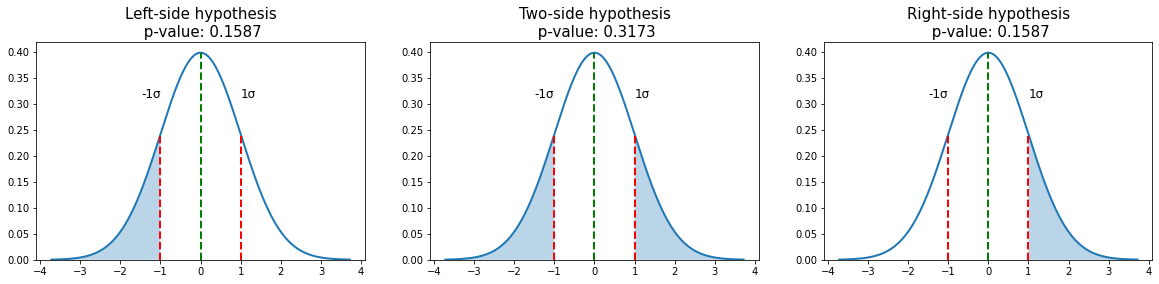

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 4))
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 1000)
norm_rv = stats.norm(loc=0, scale=1)

fish = [4, 100, 300]
text = ['Left-side hypothesis', 'Two-side hypothesis', 'Right-side hypothesis']
z = 1
coefficient = [1, 2, 1]

for i in range(3):
    ax[i].plot(x, norm_rv.pdf(x), lw = 2)
    ax[i].vlines(0, 0, norm_rv.pdf(0), color='g', lw=2, linestyles="dashed")
    ax[i].vlines([-z, z], 0, norm_rv.pdf(z), color='r', lw=2, linestyles="dashed")
    ax[i].text(z, norm_rv.pdf(z - 0.3), '{:.0f}σ'.format(z), size=12, ha='left')
    ax[i].text(-z, norm_rv.pdf(z - 0.3), '-{:.0f}σ'.format(z), size=12, ha='right')
    if (i == 0):
        ax[i].fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where = (x < -z))
    elif (i == 1): 
        ax[i].fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where = (x < -z) | (x > z))
    else:
        ax[i].fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where = (x > z))
    ax[i].set_title('{:s}\n p-value: {:.4f}'.format(text[i], (1-norm_rv.cdf(z)) * coefficient[i]), size=15)
    ax[i].set_ylim(0)

- If we know beforehand that the result will be better than we need to use right-side theory.
- If we know that it will be worse - left-sde theory.
- If we don't know beforehand will it be better or not - use two-side theory.